In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
consumer_spending = pd.read_csv('./consumer_spending_long 3.csv')
consumer_spending = consumer_spending.drop(labels=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

In [3]:
print(consumer_spending.columns)

Index(['observation_date', 'PCE'], dtype='object')


In [4]:
consumer_sentiment = pd.read_csv('./sentiment_data.csv')
consumer_sentiment = consumer_sentiment.drop(labels=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

In [5]:
print(consumer_sentiment.columns)

Index(['observation_date', 'UMCSENT'], dtype='object')


Calculate percentage year on year change

In [6]:
date_range = pd.period_range("1959-01", "2020-03",freq='m')
df_spending= pd.DataFrame({'A': consumer_spending[['PCE']].to_numpy().flatten(), 'Date': consumer_spending[['observation_date']].to_numpy().flatten()}, index=date_range)
df_spending['pct_pop'] = df_spending['A'].pct_change()
df_spending['pct_yoy'] = df_spending['A'].pct_change(12)

In [7]:
print(df_spending.columns)

Index(['A', 'Date', 'pct_pop', 'pct_yoy'], dtype='object')


In [8]:
date_range = pd.period_range("1952-11", "2020-03",freq='m')
df_conf= pd.DataFrame({'A': consumer_sentiment[['UMCSENT']].to_numpy().flatten(), 'Date': consumer_sentiment[['observation_date']].to_numpy().flatten()}, index=date_range)
df_conf['pct_pop'] = df_conf['A'].pct_change()
df_conf['pct_yoy'] = df_conf['A'].pct_change(12)

In [9]:
print(df_conf.columns)

Index(['A', 'Date', 'pct_pop', 'pct_yoy'], dtype='object')


Load S&P 500 data

In [10]:
st_p = pd.read_csv('data_csv.csv')
df_stp = st_p.copy()
df_stp = df_stp.drop(labels=['Dividend', 'Earnings', 'Consumer Price Index',
       'Long Interest Rate', 'Real Price', 'Real Dividend', 'Real Earnings',
       'PE10'], axis = 1)

In [11]:
print(df_stp.columns)

Index(['Date', 'SP500'], dtype='object')


In [12]:
# start_date = time.strptime('1960-01-01', '%Y-%m-%d')

In [13]:
df_spending['Date'] = df_spending['Date'].astype('datetime64[ns]')
df_spending = df_spending[(df_spending['Date'].dt.year >= 1985)]
df_spending = df_spending.set_index('Date')

In [14]:
df_conf['Date'] = df_conf['Date'].astype('datetime64[ns]')
df_conf = df_conf[(df_conf['Date'].dt.year >= 1985)]
df_conf = df_conf.set_index('Date')

In [15]:
df_stp['Date'] = df_stp['Date'].astype('datetime64[ns]')
df_stp = df_stp[(df_stp['Date'].dt.year >= 1985)]
df_stp = df_stp.set_index('Date', drop=False)

In [16]:
merged = pd.merge(df_stp, df_conf, left_index=True, right_index=True)
merged = merged.drop(labels=['A', 'pct_pop'], axis=1)
merged = merged.rename(columns={'pct_yoy': 'confidence'})
merged = pd.merge(merged, df_spending, left_index=True, right_index=True)
merged = merged.drop(labels=['A', 'pct_pop'], axis=1)
merged = merged.rename(columns={'pct_yoy': 'spending'})
print(merged.columns)

Index(['Date', 'SP500', 'confidence', 'spending'], dtype='object')


In [17]:
scaler_1 = MinMaxScaler()
scaler_2 = MinMaxScaler()

dates = merged[['Date']].to_numpy().flatten()
perf = np.log(merged[['SP500']].to_numpy().flatten())

conf = merged[['confidence']].to_numpy().flatten()
conf_copy = np.nan_to_num(conf).reshape(-1, 1)
scaler_1.fit(conf_copy)
conf_scaled = scaler_1.fit_transform(conf_copy)

spend = merged[['spending']].to_numpy().flatten()
spend_copy = np.nan_to_num(spend).reshape(-1, 1)
scaler_2.fit(spend_copy)
spend_scaled = scaler_2.transform(spend_copy)
# print(conf_scaled.flatten())

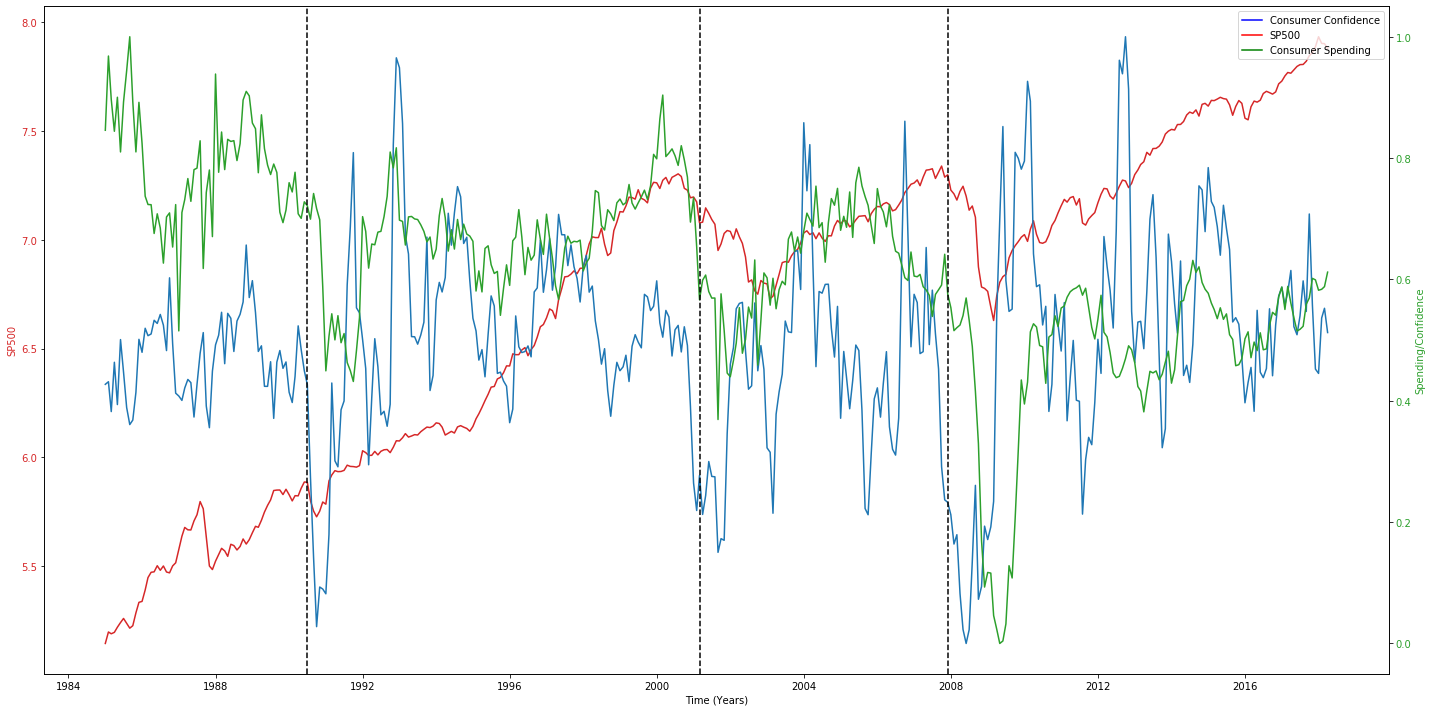

In [19]:
fig, ax1 = plt.subplots()
plt.rcParams["figure.figsize"] = [20, 10]

color = 'tab:red'
ax1.set_xlabel('Time (Years)')
ax1.set_ylabel('SP500', color=color)
l1 = ax1.plot(dates, perf, color=color, label='SP500')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
# ax2.set_ylabel('Confidence', color=color)  # we already handled the x-label with ax1
ax2.plot(dates, conf_scaled, color=color)
ax2.tick_params(axis='y', labelcolor=color)

color = 'tab:green'
ax2.set_ylabel('Spending/Confidence', color=color)  # we already handled the x-label with ax1
ax2.plot(dates, spend_scaled, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
blue_line = mlines.Line2D([], [], color='blue',
                          markersize=15, label='Consumer Confidence')
red_line = mlines.Line2D([], [], color='red',
                          markersize=15, label='SP500')
green_line = mlines.Line2D([], [], color='green',
                          markersize=15, label='Consumer Spending')
plt.legend(handles=[blue_line, red_line, green_line])
# plt.legend([*handles_2], [*labels_2])
plt.axvline(pd.Timestamp(year=1990, month=7, day=1), color='black', linestyle='--')
plt.axvline(pd.Timestamp(year=2001, month=3, day=1), color='black', linestyle='--')
plt.axvline(pd.Timestamp(year=2007, month=12, day=1), color='black', linestyle='--')

fig1 = plt.gcf()
plt.show()
fig1.savefig('./analysis.png')